In [ ]:
#@markdown ### Colab ÎÖ∏Ìä∏Î∂Å Dependency ÏÑ§ÏπòÌïòÍ∏∞
#@markdown - Colab ÎÖ∏Ìä∏Î∂ÅÏùÑ ÏÇ¨Ïö©ÌïòÎäîÎç∞ ÌïÑÏöîÌïú PackagesÎ•º ÏÑ§ÏπòÌï©ÎãàÎã§.
#@markdown ---

from IPython.display import clear_output
import ipywidgets as widgets

def inf(msg, style, wdth): 
    inf = widgets.Button(description=msg, disabled=True, button_style=style, layout=widgets.Layout(min_width=wdth));display(inf)
    
C_default = "\033[0;39m"
C_yellow = "\033[1;93m"

print(C_yellow + "Install..." + C_default)
# START

!pip install gdown==v4.6.3

# END CODE
clear_output()
inf('\u2714 Done', 'success', '50px')

Button(button_style='success', description='‚úî Done', disabled=True, layout=Layout(min_width='50px'), style=But‚Ä¶

In [ ]:
#@markdown ### DBNet Resources Îã§Ïö¥Î°úÎìú (Google Drive)

#@markdown ÎØ∏Î¶¨ Ï§ÄÎπÑÎêú Îã§Ïùå ÌååÏùºÏùÑ ÏÑ§Ï†ïÌïú Í≤ΩÎ°úÏóê Îã§Ïö¥Î°úÎìú Î∞õÏäµÎãàÎã§.
#@markdown - Model checkpoint
#@markdown - requirements.txt
#@markdown ---

print(C_yellow + "Download..." + C_default)
# START

GDrive_URL = "https://drive.google.com/drive/folders/1TYvjiTivRJcIrLytshcEaaooLie9s4pU?usp=sharing" #@param {type:"string"}
Download_Path = "/content/DB" #@param {type:"string"}

!mkdir -p {Download_Path}
!gdown {GDrive_URL} -O {Download_Path} --folder

print(C_yellow + "Install..." + C_default)
!pip install -r {Download_Path}/requirements.txt

# END CODE
clear_output()
inf('\u2714 Done', 'success', '50px')

Button(button_style='success', description='‚úî Done', disabled=True, layout=Layout(min_width='50px'), style=But‚Ä¶

In [ ]:
#@title Ìå®ÌÇ§ÏßÄ ÏûÑÌè¨Ìä∏
import os
import sys
import math
import numpy as np
from collections import OrderedDict
from itertools import accumulate

# PyTorch Model Í¥ÄÎ†®
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.model_zoo as model_zoo
import timm

# Image Processing Î∞è Visualization Í¥ÄÎ†®
import cv2
from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2
from shapely.geometry import Polygon
import pyclipper
from tqdm import tqdm
import matplotlib.pyplot as plt

## 2. DBNet Î™®Îç∏ Íµ¨ÌòÑÏ≤¥ ÏïåÏïÑÎ≥¥Í∏∞

```
üí° Î™©Ï∞® Í∞úÏöî: DBNet Î™®Îç∏ÏùÑ Íµ¨ÏÑ±ÌïòÎäî Í∞Å Î∂ÄÎ∂ÑÏùò Íµ¨Ï°∞Ïóê ÎåÄÌï¥ÏÑú ÏïåÏïÑÎ≥∏Îã§.
```
1. Encoder
 - Ïù¥ÎØ∏ÏßÄÏóêÏÑú Îã§ÏñëÌïú ScaleÎ°ú FeatureÎ•º Ï∂îÏ∂úÌïòÎäî Îã®Í≥Ñ
 - Timm Pretrained Backbone model : [Timm](https://timm.fast.ai/)

2. Decoder
 - Encoder ÏóêÏÑú Ï∂îÏ∂úÎêú FeatureÎ•º Í≤∞Ìï©ÌïòÏó¨ ÌÖçÏä§Ìä∏ ÏòÅÏó≠ Ï†ïÎ≥¥Î°ú Î≥µÏõêÌïòÎäî Îã®Í≥Ñ
 - UNet Íµ¨Ï°∞

3. Head
 - Î≥µÏõêÎêú ÌÖçÏä§Ìä∏ ÏòÅÏó≠ Ï†ïÎ≥¥Î•º Î∞îÌÉïÏúºÎ°ú ÌÖçÏä§Ìä∏ ÏòÅÏó≠Ïùò Í≤ΩÍ≥ÑÎ•º ÏòàÏ∏°ÌïòÎäî Îã®Í≥Ñ
 - Probability map
   : ÌÖçÏä§Ìä∏ ÏòÅÏó≠Ïóê ÎåÄÌïú Segmentation map
 - Threshold map
   : Probability mapÏùò Í∞Å ÌîΩÏÖÄÏóê ÎåÄÌïú Ïù¥ÏßÑÌôî ÏûÑÍ≥ÑÍ∞í

In [ ]:
#@title DBNet Encoder (Timm Resnet-18)

### Pretrained Backnone model
class TimmBackbone(nn.Module):
    def __init__(self, model_name='resnet18',    # Timm Î∞±Î≥∏ Î™®Îç∏ ÏÑ†ÌÉù
                 select_features=[1, 2, 3, 4],   # UNetÍ≥º Ïó∞Í≤∞Ìïú Feature LayerÏßÄÏ†ï
                 pretrained=True):
        super(TimmBackbone, self).__init__()

        # Timm ÎùºÏù¥Î∏åÎü¨Î¶¨Î•º ÏÇ¨Ïö©ÌïòÏó¨ ÏÇ¨Ï†Ñ ÌõàÎ†®Îêú Î∞±Î≥∏ Î™®Îç∏ÏùÑ Î∂àÎü¨Ïò§Í∏∞
        self.model = timm.create_model(model_name, pretrained=pretrained, features_only=True)

        # DecoderÏóê Ïó∞Í≤∞ÌïòÎ†§Îäî FeatureÎ•º ÏÑ†ÌÉù
        self.select_features = select_features

    def forward(self, x):
        features = self.model(x)

        # Î∞±Î≥∏ Î™®Îç∏Ïùò ÏÑ†ÌÉùÎêú Feature EmbeddingsÎßå Î∞òÌôò
        return [features[i] for i in self.select_features]

In [ ]:
#@title DBNet EncoderÏùò Shape ÌôïÏù∏

dummy_input = torch.randn((1, 3, 640, 640), dtype=torch.float32)  # ÏûÖÎ†• ÌÅ¨Í∏∞Î•º 640 * 640 ÏúºÎ°ú Í∞ÄÏ†ïÌï† Îïå

encoder = TimmBackbone()
encoder_outs = encoder(dummy_input)
for idx, out in enumerate(encoder_outs):
    print(f"{idx}: {out.shape}")             # Î∞±Î≥∏ ShapeÏùÑ Ï£ºÏùòÍπäÍ≤å ÏÇ¥Ìé¥Î¥ÖÎãàÎã§.

model.safetensors:   0%|          | 0.00/46.8M [00:00<?, ?B/s]

0: torch.Size([1, 64, 160, 160])
1: torch.Size([1, 128, 80, 80])
2: torch.Size([1, 256, 40, 40])
3: torch.Size([1, 512, 20, 20])


### DBNetÏùò Decoder (UNet) Íµ¨Ï°∞

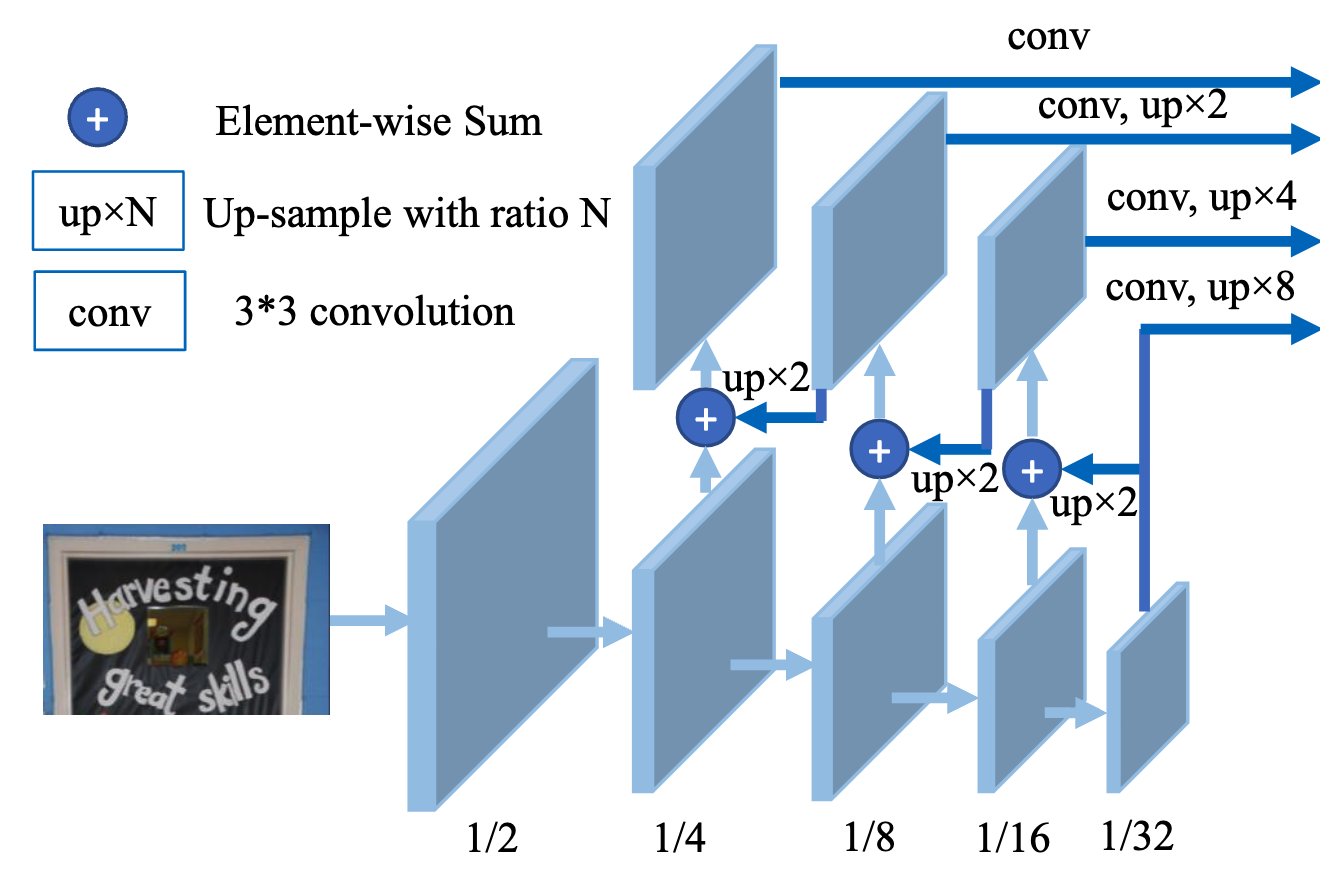

In [ ]:
#@title DBNet Decoder (UNet)

class UNet(nn.Module):
    def __init__(self,
                 in_channels=[64, 128, 256, 512],  # EncoderÏùò Feature ChannelsÏôÄ ÏùºÏπò
                 strides=[4, 8, 16, 32],           # Decoder Scale Factors
                 inner_channels=256,               # Decoder Inner channels (Hidden layer channels)
                 output_channels=64,               # Decoder Output channels
                 bias=False):
        super(UNet, self).__init__()

        assert len(strides) == len(in_channels), "Mismatch in 'strides' and 'in_channels' lengths."

        # ParametersÏóê Îî∞Îùº UNet Íµ¨Ï°∞Î•º ÎèôÏ†ÅÏúºÎ°ú ÏÉùÏÑ±
        # Decoder size Í≥ÑÏÇ∞
        # UNet Íµ¨Ï°∞Ïùò Íµ¨ÌòÑÏ≤¥Î°úÏÑú, Width, HeightÍ∞Ä Ï§ÑÏñ¥Îì†ÎßåÌÅº ÌÅ¨Í∏∞Î•º Î≥µÏõêÌïòÍ∏∞ ÏúÑÌïú ratio Î≥ÄÏàò
        upscale_factors = [strides[idx] // strides[idx - 1] for idx in range(1, len(strides))]
        outscale_factors = list(accumulate(upscale_factors, lambda x, y: x * y))

        # Up-sample Íµ¨Ï°∞Î•º ÏúÑÌïú LayersÎ•º ÏÉùÏÑ± : Í∞Å Ï∏µÏùò Ï∞®Ïù¥ÎßåÌÅº FeatureÎ•º ÌôïÎåÄ
        self.upsamples = nn.ModuleList()
        for upscale in upscale_factors:
            self.upsamples.append(nn.Upsample(scale_factor=upscale, mode='nearest'))

        # EncoderÏôÄ DecoderÎ•º Ïó∞Í≤∞ÌïòÎäî Skip connection layersÎ•º ÏÉùÏÑ±
        self.inners = nn.ModuleList()
        for in_channel in in_channels:
            self.inners.append(nn.Conv2d(in_channel, inner_channels, kernel_size=1, bias=bias))

        # Í∞Å Ï∏µÏùò Í≤∞Í≥ºÎ•º Ï∂úÎ†•ÌïòÎäî layersÎ•º ÏÉùÏÑ±: outscale_factorsÏóê Îî∞Îùº width, heightÎ•º ÌôïÎåÄ
        self.outers = nn.ModuleList()
        for outscale in reversed(outscale_factors):
            outer = nn.Sequential(nn.Conv2d(inner_channels, output_channels,
                                            kernel_size=3, padding=1, bias=bias),
                                  nn.Upsample(scale_factor=outscale, mode='nearest'))
            self.outers.append(outer)
        self.outers.append(nn.Conv2d(inner_channels, output_channels, kernel_size=3,
                                     padding=1, bias=bias))

        # Weight Ï¥àÍ∏∞Ìôî
        self.upsamples.apply(self.weights_init)
        self.inners.apply(self.weights_init)
        self.outers.apply(self.weights_init)

    def weights_init(self, m):
        classname = m.__class__.__name__
        if classname.find('Conv') != -1:
            nn.init.kaiming_normal_(m.weight.data)
        elif classname.find('BatchNorm') != -1:
            m.weight.data.fill_(1.)
            m.bias.data.fill_(1e-4)

    def forward(self, features):
        # EncoderÏùò Feature embeddingsÎ•º Í∞ÅÍ∞Å ÏûÖÎ†•
        in_features = [inner(feat) for feat, inner in zip(features, self.inners)]

        # Upsample
        up_features = []
        up = in_features[-1]
        for i in range(len(in_features) - 1, 0, -1):
            up = self.upsamples[i - 1](up) + in_features[i - 1]
            up_features.append(up)

        # UNet Output
        out_features = [self.outers[0](in_features[-1])]
        out_features += [outer(feat) for feat, outer in zip(up_features, self.outers[1:])]

        return out_features


In [ ]:
#@title DBNet DecoderÏùò Shape ÌôïÏù∏

decoder = UNet()
decoder_outs = decoder(encoder_outs)
for idx, out in enumerate(decoder_outs):
    print(f"{idx}: {out.shape}")             # Decoder ShapeÏùÑ Ï£ºÏùòÍπäÍ≤å ÏÇ¥Ìé¥Î¥ÖÎãàÎã§.
                                             # DBNet Í∏∞Î≥∏ Íµ¨Ï°∞Î•º ÏÇ¥Ìé¥Î≥¥Î©¥, ÏûÖÎ†• Ïù¥ÎØ∏ÏßÄÏùò 1/4 ÌÅ¨Í∏∞Î°ú Ï∂úÎ†•ÏùÑ Íµ¨Ìï®

0: torch.Size([1, 64, 160, 160])
1: torch.Size([1, 64, 160, 160])
2: torch.Size([1, 64, 160, 160])
3: torch.Size([1, 64, 160, 160])


In [ ]:
#@title DBNet Head Î™®Îç∏

class DBHead(nn.Module):
    def __init__(self, in_channels=256,       # DecoderÏùò Output ChannelsÏôÄ ÏùºÏπò (decoderÏùò outputsÎ•º concat)
                       upscale=4,             # DecoderÏùò OutputÏùÑ ÏûÖÎ†• ImageÏùò ÏÇ¨Ïù¥Ï¶àÏóê ÎßûÍ≤å ÌôïÎåÄ
                       k=50,                  # DB Step FunctionÏóêÏÑú ÏÇ¨Ïö©ÌïòÎäî Amplifying factor
                       bias=False,
                       smooth=False):
        super(DBHead, self).__init__()

        self.in_channels = in_channels
        self.inner_channels = in_channels // 4
        self.k = k

        # Feature embeddingÏùÑ UpscaleÏóê Îî∞Îùº ÌôïÏû•: UpscaleÏóê ÌïÑÏöîÌïú Layer DepthÎ•º Í≥ÑÏÇ∞
        self.upscale = int(math.log2(upscale))

        # Probability map
        # UpscaleÏóê Îî∞Îùº ConvTranspose2d LayerÎ•º ÎèôÏ†ÅÏúºÎ°ú ÏÉùÏÑ±
        # ex) ConvTranspose2d ‚Üí BatchNorm2d ‚Üí ReLU ‚Üí ... ‚Üí ConvTranspose2d ‚Üí Sigmoid
        binarize_layers = [nn.Conv2d(self.in_channels, self.inner_channels, kernel_size=3,
                                     padding=1, bias=bias),
                           nn.BatchNorm2d(self.inner_channels),
                           nn.ReLU(inplace=True)]
        for i in range(self.upscale):
            if i == self.upscale - 1:
                binarize_layers.append(
                    nn.ConvTranspose2d(self.inner_channels, 1, 2, 2)
                )
            else:
                binarize_layers.append(nn.ConvTranspose2d(self.inner_channels,
                                                          self.inner_channels, 2, 2))
                binarize_layers.append(nn.BatchNorm2d(self.inner_channels))
                binarize_layers.append(nn.ReLU(inplace=True))
        binarize_layers.append(nn.Sigmoid())
        self.binarize = nn.Sequential(*binarize_layers)

        # Threshold map
        self.thresh = self._init_thresh(smooth=smooth, bias=bias)

        # Weight Ï¥àÍ∏∞Ìôî
        self.binarize.apply(self.weights_init)
        self.thresh.apply(self.weights_init)

    def _init_thresh(self, smooth=False, bias=False):
        # UpscaleÏóê Îî∞Îùº Upsample LayerÎ•º ÎèôÏ†ÅÏúºÎ°ú ÏÉùÏÑ±
        # ex) ConvTranspose2d ‚Üí BatchNorm2d ‚Üí ReLU ‚Üí ... ‚Üí ConvTranspose2d ‚Üí Sigmoid
        # Smooth Í∞Ä TrueÏù∏ Í≤ΩÏö∞, Threshold map Í≤∞Í≥ºÏùò Î™®Îàà ÌòÑÏÉÅÏùÑ Í∞êÏÜåÏãúÌÇ§Í∏∞ ÏúÑÌïòÏó¨ UpsampleÏùÑ ÏÇ¨Ïö©
        thresh_layers = [nn.Conv2d(self.in_channels, self.inner_channels, kernel_size=3,
                                   padding=1, bias=bias),
                         nn.BatchNorm2d(self.inner_channels),
                         nn.ReLU(inplace=True)]
        for i in range(self.upscale):
            if i == self.upscale - 1:
                thresh_layers.append(self._init_upsample(self.inner_channels, out_channels=1,
                                                         smooth=smooth, bias=bias))
            else:
                thresh_layers.append(self._init_upsample(self.inner_channels, self.inner_channels,
                                                         smooth=smooth, bias=bias))
                thresh_layers.append(nn.BatchNorm2d(self.inner_channels))
                thresh_layers.append(nn.ReLU(inplace=True))
        thresh_layers.append(nn.Sigmoid())
        thresh = nn.Sequential(*thresh_layers)

        return thresh

    def _init_upsample(self, in_channels, out_channels, smooth=False, bias=False):
        # Smooth Í∞Ä TrueÏù∏ Í≤ΩÏö∞, ConvTranspose2d ÎåÄÏã† UpsampleÏùÑ ÏÇ¨Ïö©
        if smooth:
            inter_out_channels = out_channels
            if out_channels == 1:
                inter_out_channels = in_channels
            module_list = [
                    nn.Upsample(scale_factor=2, mode='nearest'),
                    nn.Conv2d(in_channels, inter_out_channels, 3, padding=1, bias=bias)]
            if out_channels == 1:
                module_list.append(
                    nn.Conv2d(in_channels, out_channels,
                              kernel_size=1, stride=1, padding=0, bias=True))
            return nn.Sequential(*module_list)
        else:
            return nn.ConvTranspose2d(in_channels, out_channels, 2, 2)

    def _step_function(self, x, y):
        # Probability mapÍ≥º ThresholdmapÏùÑ Ïù¥Ïö©ÌïòÏó¨ Approximate Binary Map ÏÉùÏÑ±
        return torch.reciprocal(1 + torch.exp(-self.k * (x - y)))

    def weights_init(self, m):
        classname = m.__class__.__name__
        if classname.find('Conv') != -1:
            nn.init.kaiming_normal_(m.weight.data)
        elif classname.find('BatchNorm') != -1:
            m.weight.data.fill_(1.)
            m.bias.data.fill_(1e-4)

    def forward(self, features, return_loss=True):
        # Input feature concat
        fuse = torch.cat(features, dim=1)

        # Probability map
        binary = self.binarize(fuse)

        # Î™®Îç∏ ÌïôÏäµ Îã®Í≥ÑÏóêÏÑúÎßå Threshold mapÏùÑ Í≥ÑÏÇ∞
        # Ï∂îÎ°† Îã®Í≥ÑÏóêÏÑúÎäî Probability mapÏùÑ Binarization mapÏúºÎ°ú ÏÇ¨Ïö© (ÌïôÏäµÎêú Î™®Îç∏ÏóêÏÑúÎäî Í≤∞Í≥ºÏùò Ï∞®Ïù¥Í∞Ä Í±∞Ïùò ÏóÜÏùå)
        if return_loss:
            # Threshold map
            thresh = self.thresh(fuse)

            # Approximate Binary map
            thresh_binary = self._step_function(binary, thresh)
            result = OrderedDict(prob_maps=binary, thresh_maps=thresh, binary_maps=thresh_binary)
        else:
            # Probability map only - Inference mode
            result = OrderedDict(prob_maps=binary)

        return result

In [ ]:
#@title DBNet Model Architecture

class OCRModel(nn.Module):
    def __init__(self):
        super(OCRModel, self).__init__()

        # Í∞Å Î™®Îìà instantiate
        self.encoder = TimmBackbone()
        self.decoder = UNet()
        self.head = DBHead()

    def forward(self, images, return_loss=True, **kwargs):
        # Î™®Îç∏ Ï∂îÎ°†
        encoded_features = self.encoder(images)
        decoded_features = self.decoder(encoded_features)
        pred = self.head(decoded_features, return_loss)
        return pred

## 2. DBNet Î™®Îç∏ Ï∂îÎ°†Í≥ºÏ†ï ÏïåÏïÑÎ≥¥Í∏∞

```
üí° Î™©Ï∞® Í∞úÏöî: Íµ¨ÌòÑÌïú DBNet Î™®Îç∏Î°ú ÏòÅÏàòÏ¶ù Ïù¥ÎØ∏ÏßÄÎ•º Ï∂îÎ°†Ìï¥Î≥¥Í≥†, ÌõÑÏ≤òÎ¶¨Î•º Í±∞Ï≥ê ÌÖçÏä§Ìä∏ ÏòÅÏó≠ÏùÑ Í≤ÄÏ∂úÌïòÎäî Í≥ºÏ†ïÏùÑ ÏïåÏïÑÎ≥∏Îã§.
```
1. Î™®Îç∏ ÏÑ†Ïñ∏ Î∞è Weight Î∂àÎü¨Ïò§Í∏∞

2. Îç∞Ïù¥ÌÑ∞ Ï†ÑÏ≤òÎ¶¨ Î∞è Î™®Îç∏ Ï∂îÎ°†

3. Ï∂îÎ°† Í≤∞Í≥º ÌõÑÏ≤òÎ¶¨ Î∞è ÏãúÍ∞ÅÌôî

In [ ]:
#@title Î™®Îç∏ ÏÑ†Ïñ∏ Î∞è Weight Î∂àÎü¨Ïò§Í∏∞

# Model architecture ÏÑ†Ïñ∏
device = torch.device("cuda")
model = OCRModel().to(device)

# Load pretrained model weight
Model_Path = Download_Path + '/dbnet-receipt.ckpt'
if not os.path.exists(Model_Path):
    print("Checkpoint not found: " + Model_Path)

states = torch.load(Model_Path, map_location=device)
model.load_state_dict(states, strict=True)

model.eval()
# Î™®Îç∏ Íµ¨Ï°∞ Ï∂úÎ†•

OCRModel(
  (encoder): TimmBackbone(
    (model): FeatureListNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act1): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (drop_block): Identity()
          (act1): ReLU(inplace=True)
          (aa): Identity()
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (act2): ReLU(inplace=True)
        )
        (1): BasicBlock(
          (c

In [ ]:
#@markdown ### DBNet Inference Test Ïù¥ÎØ∏ÏßÄ Îã§Ïö¥Î°úÎìú (Google Drive)
#@markdown ---

print(C_yellow + "Download..." + C_default)
# START

GDrive_URL = "https://drive.google.com/drive/folders/1FBEafD3Zua86kb5TodVUgAk5SgRuIUJ4?usp=drive_link" #@param {type:"string"}
Dataset_Path = "/content/Dataset" #@param {type:"string"}

!mkdir -p {Dataset_Path}
!gdown {GDrive_URL} -O {Dataset_Path} --folder

# END CODE
clear_output()
inf('\u2714 Done', 'success', '50px')

Button(button_style='success', description='‚úî Done', disabled=True, layout=Layout(min_width='50px'), style=But‚Ä¶

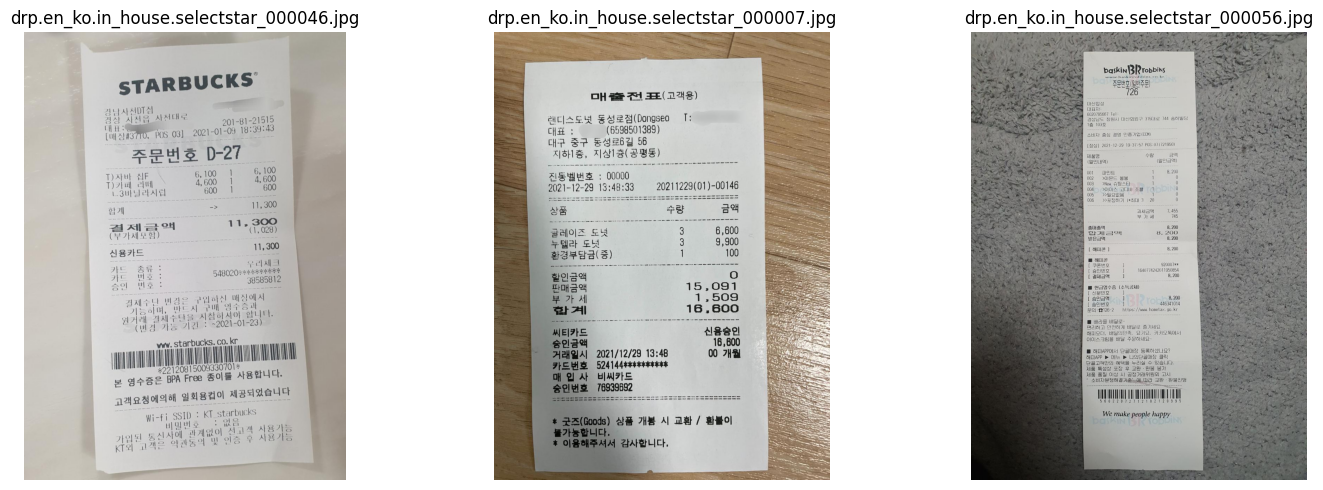

In [ ]:
#@title ÌÖåÏä§Ìä∏ Ïù¥ÎØ∏ÏßÄ ÏãúÍ∞ÅÌôî

folder_path = os.path.join(Dataset_Path, 'images/test')

# Ìè¥ÎçîÏóêÏÑú Ïù¥ÎØ∏ÏßÄ ÌååÏùº Î™©Î°ù Í∞ÄÏ†∏Ïò§Í∏∞ (JPEG Î∞è PNG ÌååÏùºÎßå)
image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

# Ïù¥ÎØ∏ÏßÄ ÏàòÏóê Îî∞Îùº ÌñâÏùò Ïàò Í≥ÑÏÇ∞
n_rows = len(image_files) // 3 + int(len(image_files) % 3 > 0)

# Ïù¥ÎØ∏ÏßÄ ÌëúÏãú
test_images = []
plt.figure(figsize=(15, 5 * n_rows))
for i, file in enumerate(image_files):
    img_path = os.path.join(folder_path, file)

    # OpenCVÎ•º ÏÇ¨Ïö©ÌïòÏó¨ Ïù¥ÎØ∏ÏßÄ Î°úÎìú
    img = cv2.imread(img_path)
    test_images.append(img)

    # BGRÏóêÏÑú RGBÎ°ú Î≥ÄÌôò
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.subplot(n_rows, 3, i + 1)
    plt.imshow(img)
    plt.title(file)
    plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
#@title DBNet Îç∞Ïù¥ÌÑ∞ Ï†ÑÏ≤òÎ¶¨

# Albumentations Î≥ÄÌôò Ï†ïÏùò : ÏûÖÎ†• ÏÇ¨Ïù¥Ï¶à Î≥ÄÌôò Î∞è Padding, Normalize, TensorÎ≥ÄÌôò
transform = A.Compose([
    A.LongestMaxSize(max_size=640, p=1.0),
    A.PadIfNeeded(min_width=640, min_height=640, border_mode=0, p=1.0),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])


# Ï§ÑÏñ¥Îì† Ïù¥ÎØ∏ÏßÄ ÏÇ¨Ïù¥Ï¶àÎ•º ÏûÖÎ†• Ïù¥ÎØ∏ÏßÄ ÏÇ¨Ïù¥Ï¶àÎ°ú Î≥µÏõêÌïòÍ∏∞ ÏúÑÌïú Inverse MatrixÎ•º Í≥ÑÏÇ∞
def calculate_inverse_transform(original_size, transformed_size, crop_box=None):
    ox, oy = original_size
    tx, ty = transformed_size
    cx, cy = 0, 0
    if crop_box:
        cx, cy, tx, ty = crop_box

    # Scale back to the original size
    scale_x = ox / tx
    scale_y = oy / ty
    scale_matrix = np.array([
        [scale_x, 0, 0],
        [0, scale_y, 0],
        [0, 0, 1]
    ])

    # Padding back to the original size
    translation_matrix = np.eye(3)
    translation_matrix[0, 2] = -cx
    translation_matrix[1, 2] = -cy

    # ÌïòÎÇòÏùò Îß§Ìä∏Î¶≠Ïä§Î°ú Ïó≠Î≥ÄÌôò Ìï† Ïàò ÏûàÎèÑÎ°ù Îëê Îß§Ìä∏Î¶≠Ïä§Î•º Í≤∞Ìï©
    inverse_matrix = np.dot(scale_matrix, translation_matrix)
    return inverse_matrix


# Î≥ÄÌôòÎêú Ïù¥ÎØ∏ÏßÄÏùò Size Î∞è Padding ÌÅ¨Í∏∞ Í≥ÑÏÇ∞
def calculate_cropbox(original_size, target_size=640):
    ox, oy = original_size
    scale = target_size / max(ox, oy)
    new_width, new_height = int(ox * scale), int(oy * scale)
    delta_w = target_size - new_width
    delta_h = target_size - new_height
    x, y = delta_w // 2, delta_h // 2
    w, h = new_width, new_height
    return x, y, w, h


# ÌÖåÏä§Ìä∏ Ïù¥ÎØ∏ÏßÄ Ï§ÄÎπÑ Í≥ºÏ†ï
batch = []
for image in test_images:
    data = dict()
    transformed = transform(image=image)                        # Ïù¥ÎØ∏ÏßÄ Transform
    transformed_image = transformed["image"]
    data['images'] = transformed_image.unsqueeze(0).to(device)  # Î™®Îç∏ Ï∂îÎ°†ÏùÑ ÏúÑÌïú Î≥ÄÌôòÎêú Ïù¥ÎØ∏ÏßÄ Ï†ÄÏû•
    data['origin_images'] = [image]                             # VisualizationÏùÑ ÏúÑÌïú ÏõêÎ≥∏ Ïù¥ÎØ∏ÏßÄ Ï†ÄÏû•

    # Ï∂îÎ°† Í≤∞Í≥ºÎ•º ÏõêÎ≥∏ Ïù¥ÎØ∏ÏßÄ ÌÅ¨Í∏∞Î°ú Î≥ÄÌôòÌïòÍ∏∞ ÏúÑÌïú Inverse Matrix Ï†ÄÏû•
    height, width, _ = image.shape
    _, new_height, new_width = transformed_image.shape
    crop_box = calculate_cropbox((width, height), max(new_height, new_width))
    inverse_matrix = calculate_inverse_transform((width, height),
                                                 (new_width, new_height),
                                                 crop_box=crop_box)
    data['inverse_matrix'] = [inverse_matrix]

    batch.append(data)

In [ ]:
#@title DBNet Î™®Îç∏ Ï∂îÎ°†

preds = []
for data in tqdm(batch):
    # ÏùºÎ∞òÏ†ÅÏù∏ Ï∂îÎ°† Í≥ºÏ†ïÏóêÏÑúÎäî Threshold mapÏùÑ ÏÉùÎûµÌïòÏßÄÎßå, Ïã§Ïäµ ÏòàÏ†úÏóêÏÑúÎäî Threshold map ÏãúÍ∞ÅÌôîÎ•º ÏúÑÌï¥ ÏÇ¨Ïö©
    # preds.append(model(data['images'], return_loss=False)  # ÏùºÎ∞òÏ†ÅÏù∏ Ï∂îÎ°† Í≥ºÏ†ï
    preds.append(model(data['images']))

100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 3/3 [00:01<00:00,  1.78it/s]


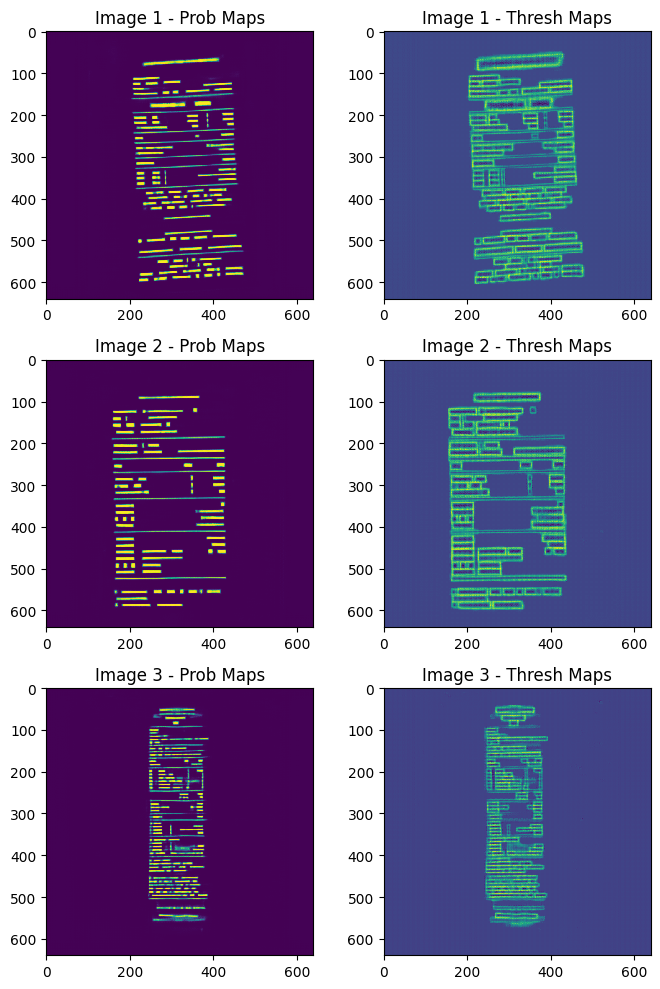

In [ ]:
#@title DBNet Î™®Îç∏ Ï∂îÎ°† Í≤∞Í≥º ÏãúÍ∞ÅÌôî

# Plotting
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(7, 10))

for i, output in enumerate(preds):
    prob_maps = output['prob_maps'].squeeze(0).detach().cpu().squeeze(0)
    thresh_maps = output['thresh_maps'].squeeze(0).detach().cpu().squeeze(0)

    axes[i, 0].imshow(prob_maps, cmap='viridis', interpolation='nearest')
    axes[i, 0].set_title(f'Image {i+1} - Prob Maps')

    axes[i, 1].imshow(thresh_maps, cmap='viridis', interpolation='nearest')
    axes[i, 1].set_title(f'Image {i+1} - Thresh Maps')

plt.tight_layout()
plt.show()

In [ ]:
#@title Ï∂îÎ°† Í≤∞Í≥º ÌõÑÏ≤òÎ¶¨Î•º ÏúÑÌïú Class

class DBPostProcessor:
    def __init__(self, thresh=0.3, box_thresh=0.4, max_candidates=300, use_polygon=False):
        self.min_size = 3                       # ÌÖçÏä§Ìä∏ Í≤ÄÏ∂ú ÏµúÏÜå ÏÇ¨Ïù¥Ï¶à
        self.thresh = thresh                    # Î™®Îç∏Ïùò Ï∂úÎ†• Í≤∞Í≥º Segmentation mapÏùÑ Binarization ÌïòÍ∏∞ ÏúÑÌïú Threshold
        self.box_thresh = box_thresh            # ÌÖçÏä§Ìä∏ ÏòÅÏó≠ ÌåêÏ†ïÏùÑ ÏúÑÌïú Threshold
        self.max_candidates = max_candidates    # ÏµúÎåÄ ÌÖçÏä§Ìä∏ Í≤ÄÏ∂ú ÌõÑÎ≥¥ ÏòÅÏó≠Ïùò Í∞ØÏàò
        self.use_polygon = use_polygon          # Polygon Í≤ÄÏ∂úÏùÑ Ìï†ÏßÄ Quad Í≤ÄÏ∂úÏùÑ Ìï†ÏßÄÏóê ÎåÄÌïú Type flag

    # Segmentation map Í≤∞Í≥ºÎ°úÎ∂ÄÌÑ∞ ÌÖçÏä§Ìä∏ ÏòÅÏó≠Ïùò Ï¢åÌëúÎ•º Î∞òÌôòÌïòÎäî Î©îÏÜåÎìú
    def represent(self, batch, _pred):
        """
        batch: a dict produced by dataloaders.
            images: tensor of shape (N, C, H, W).
            polygons: tensor of shape (N, K, 4, 2), the polygons of objective regions.
            ignore_tags: tensor of shape (N, K), indicates whether a region is ignorable or not.
            shape: the original shape of images.
            inverse_matrix: Warp Perspective Matrix, with shape (3, 3) as NDArray[float32]
            filename: the original filenames of images.
        pred:
            prob_maps: text region segmentation map, with shape (N, 1, H, W)
        """
        assert 'images' in batch is not None, "images is required in batch"
        images = batch['images']

        # Use prob_maps if pred is a dict
        if isinstance(_pred, dict):
            assert 'prob_maps' in _pred is not None, "prob_maps is required in _pred"
            pred = _pred['prob_maps']
        else:
            pred = _pred

        assert 'inverse_matrix' in batch is not None, "inverse_matrix is required in batch"
        inverse_matrix = batch['inverse_matrix']

        # Probability mapÏùÑ Ïù¥ÏßÑÌôî
        segmentation = self.binarize(pred)

        boxes_batch = []
        scores_batch = []
        for batch_index in range(images.size(0)):
            if self.use_polygon:
                # Get polygons from segmentation
                boxes, scores = self.polygons_from_bitmap(
                                        pred[batch_index],
                                        segmentation[batch_index],
                                        inverse_matrix=inverse_matrix[batch_index])
            else:
                # Get boxes from segmentation
                boxes, scores = self.boxes_from_bitmap(
                                        pred[batch_index],
                                        segmentation[batch_index],
                                        inverse_matrix=inverse_matrix[batch_index])
            # Append to batch
            boxes_batch.append(boxes)
            scores_batch.append(scores)

        return boxes_batch, scores_batch

    @staticmethod
    # Inverse matrixÎ•º Ïù¥Ïö©ÌïòÏó¨ ÏõêÎ≥∏ Ïù¥ÎØ∏ÏßÄÏóê ÎåÄÌïú Ï¢åÌëúÎ°ú Î≥ÄÌôò ÌïòÎäî Î©îÏÜåÎìú
    def __transform_coordinates(coords, matrix):
        """
        Transform coordinates according to the warp matrix

        coords: (N, 2) as NDArray[float32]
        matrix: (3, 3) as NDArray[float32]
        return: (N, 2) as NDArray[float32]
        """
        coords = np.array(coords)
        coords = np.dot(matrix, np.vstack([coords.T, np.ones(coords.shape[0])]))
        coords /= coords[2, :]
        return coords.T[:, :2]

    # Binarize the prediction
    def binarize(self, pred):
        # ÌõÑÏ≤òÎ¶¨ Í≥ºÏ†ïÏóêÏÑú Îã®Ïùº ThresholdÎ•º ÏÇ¨Ïö©ÌïòÏó¨ Ïù¥ÏßÑÌôî
        return pred > torch.Tensor([self.thresh]).to(device=pred.device)

    # Ï∂îÎ°† Í≤∞Í≥º ÏòÅÏó≠ÏóêÏÑú ÌÖçÏä§Ìä∏ ÏòÅÏó≠ÏùÑ Í≤ÄÏ∂úÌïòÏó¨ Î∞òÌôòÌïòÎäî Î©îÏÜåÎìú (PolygonÏúºÎ°ú Ï∂îÏ∂úÌï†Îïå)
    def polygons_from_bitmap(self, pred, _bitmap,
                             inverse_matrix=None):
        """
        Extracts polygons and their scores from a bitmap image.

        _bitmap: single map with shape (1, H, W),
            whose values are binarized as {0, 1}
        """

        assert _bitmap.size(0) == 1
        bitmap = _bitmap.cpu().numpy()[0]  # The first channel
        pred = pred.cpu().detach().numpy()[0]

        boxes = []
        scores = []

        # Ïª®Ìà¨Ïñ¥ ÏòÅÏó≠ Ï∞æÍ∏∞
        # Find contours from the binarized map
        # contours: a list of contours
        # https://docs.opencv.org/4.9.0/d4/d73/tutorial_py_contours_begin.html
        contours, _ = cv2.findContours(
            (bitmap * 255).astype(np.uint8),
            cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

        # ÏµúÎåÄ ÌÖçÏä§Ìä∏ Í≤ÄÏ∂ú ÌõÑÎ≥¥ ÏòÅÏó≠Ïùò Í∞ØÏàòÎßåÌÅº Ïª®Ìà¨Ïñ¥ ÏòÅÏó≠Ïù¥ ÌÖçÏä§Ìä∏ ÏòÅÏó≠Ïù∏ÏßÄ ÌåêÎã®
        # Get the top N contours
        for contour in contours[:self.max_candidates]:
            # Î≥µÏû°Ìïú Ïª®Ìà¨Ïñ¥ ÌîΩÏÖÄÏùÑ Í∑ºÏÇ¨ÌôîÌïòÏó¨ ÏòÅÏó≠ Îã§Îì¨Í∏∞
            # Approximate the contour with Douglas-Peucker algorithm
            # https://docs.opencv.org/4.9.0/dc/dcf/tutorial_js_contour_features.html
            epsilon = 0.002 * cv2.arcLength(contour, True)
            approx = cv2.approxPolyDP(contour, epsilon, True)
            points = approx.reshape((-1, 2))
            # ÏµúÏÜå Ìè¨Ïù∏Ìä∏Í∞Ä 4Í∞ú ÎØ∏ÎßåÏù∏ Í≤ΩÏö∞ Î¨¥Ïãú
            if points.shape[0] < 4:
                continue

            # Ïª®Ìà¨Ïñ¥ ÏòÅÏó≠ÏóêÏÑú ÌÖçÏä§Ìä∏Í∞Ä Ï∞®ÏßÄÌïòÎäî ÏòÅÏó≠Ïóê ÎåÄÌïú Ï†êÏàò Í≥ÑÏÇ∞
            # Get the score of the box
            score = self.box_score_fast(pred, points.reshape(-1, 2))
            if self.box_thresh > score:
                continue

            # ShrinkÎêòÏñ¥ÏûàÎäî Ï∂îÎ°† Í≤∞Í≥ºÎ•º Îã§Ïãú DilateÌïòÎäî Í≥ºÏ†ï
            # Unclip the box
            if points.shape[0] > 2:
                box = self.unclip(points, unclip_ratio=2.0)
                if box is None:
                    continue
            else:
                continue

            # Ï£ºÏñ¥ÏßÑ ÏòÅÏó≠Ïùò ÌÅ¨Í∏∞Î•º Íµ¨ÌïòÍ≥† ÏµúÏÜå ÏÇ¨Ïù¥Ï¶à ÎØ∏ÎßåÏùò Í≤ΩÏö∞ Î¨¥Ïãú
            # Get the mini box
            box = box.reshape(-1, 2)
            _, sside = self.get_mini_boxes(box.reshape((-1, 1, 2)))
            if sside < self.min_size + 2:
                continue

            # Inverse MatrixÎ•º Ïù¥Ïö©ÌïòÏó¨ ÏõêÎ≥∏ Ïù¥ÎØ∏ÏßÄÏùò ÏúÑÏπòÎ°ú Ï¢åÌëú Î≥ÄÌôò
            # Transform the coordinates
            box = self.__transform_coordinates(box, inverse_matrix)

            # Append to the list
            boxes.append(np.round(box).astype(np.int16).tolist())
            scores.append(score)

        return boxes, scores

    # Ï∂îÎ°† Í≤∞Í≥º ÏòÅÏó≠ÏóêÏÑú ÌÖçÏä§Ìä∏ ÏòÅÏó≠ÏùÑ Í≤ÄÏ∂úÌïòÏó¨ Î∞òÌôòÌïòÎäî Î©îÏÜåÎìú (QuadBoxÎ°ú Ï∂îÏ∂úÌï†Îïå)
    # ÌÖçÏä§Ìä∏ ÏòÅÏó≠ÏùÑ Ï∞æÎäî Í≥ºÏ†ïÏùÑ Ï†úÏô∏ÌïòÍ≥† PolygonÍ≥º ÎèôÏùº
    def boxes_from_bitmap(self, pred, _bitmap,
                          inverse_matrix=None):
        """
        Extracts bounding boxes and their scores from a bitmap image.

        _bitmap: single map with shape (1, H, W),
            whose values are binarized as {0, 1}
        """

        assert _bitmap.size(0) == 1
        bitmap = _bitmap.cpu().numpy()[0]  # The first channel
        pred = pred.cpu().detach().numpy()[0]

        boxes = []
        scores = []

        # Ïª®Ìà¨Ïñ¥ ÏòÅÏó≠ Ï∞æÍ∏∞
        # Find contours from the binarized map
        # contours: a list of contours
        # https://docs.opencv.org/4.9.0/d4/d73/tutorial_py_contours_begin.html
        contours, _ = cv2.findContours(
            (bitmap * 255).astype(np.uint8),
            cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
        num_contours = min(len(contours), self.max_candidates)

        # ÏµúÎåÄ ÌÖçÏä§Ìä∏ Í≤ÄÏ∂ú ÌõÑÎ≥¥ ÏòÅÏó≠Ïùò Í∞ØÏàòÎßåÌÅº Ïª®Ìà¨Ïñ¥ ÏòÅÏó≠Ïù¥ ÌÖçÏä§Ìä∏ ÏòÅÏó≠Ïù∏ÏßÄ ÌåêÎã®
        # Get the top N contours
        for index in range(num_contours):
            # Ïª®Ìà¨Ïñ¥ ÏòÅÏó≠Ïùò Ï¢åÌëúÏôÄ ÌÅ¨Í∏∞Î•º Íµ¨ÌïòÍ≥† ÏµúÏÜå ÏÇ¨Ïù¥Ï¶à Ïù¥ÌïòÏùò Í≤ΩÏö∞ Î¨¥Ïãú
            # Get the mini box
            contour = contours[index]
            points, sside = self.get_mini_boxes(contour)
            if sside < self.min_size:
                continue

            # Ïª®Ìà¨Ïñ¥ ÏòÅÏó≠ÏóêÏÑú ÌÖçÏä§Ìä∏Í∞Ä Ï∞®ÏßÄÌïòÎäî ÏòÅÏó≠Ïóê ÎåÄÌïú Ï†êÏàò Í≥ÑÏÇ∞
            # Get the score of the box
            points = np.array(points)
            score = self.box_score_fast(pred, points.reshape(-1, 2))
            if self.box_thresh > score:
                continue

            # ShrinkÎêòÏñ¥ÏûàÎäî Ï∂îÎ°† Í≤∞Í≥ºÎ•º Îã§Ïãú DilateÌïòÎäî Í≥ºÏ†ï
            # Unclip the box
            box = self.unclip(points).reshape(-1, 1, 2)
            box, sside = self.get_mini_boxes(box)
            if sside < self.min_size + 2:
                continue
            box = np.array(box)

            # Inverse MatrixÎ•º Ïù¥Ïö©ÌïòÏó¨ ÏõêÎ≥∏ Ïù¥ÎØ∏ÏßÄÏùò ÏúÑÏπòÎ°ú Ï¢åÌëú Î≥ÄÌôò
            # Transform the coordinates
            box = self.__transform_coordinates(box, inverse_matrix)

            # Append to the list
            boxes.append(np.round(box).astype(np.int16).tolist())
            scores.append(score)

        return boxes, scores

    def unclip(self, box, unclip_ratio=1.5):
        """
        Expands the given box by a specified ratio.

        box: a list of points of shape (N, 2)
        unclip_ratio: the ratio of unclipping the box
        return: a list of points of shape (N, 2)
        """

        # transform the box to polygon
        poly = Polygon(box)
        if poly.area == 0 or poly.length == 0:
            return None

        # get the expanded polygon
        # unclip_ratioÏùò ÎπÑÏú®Î°ú ÌôïÎåÄÎêú DistanceÎ•º Íµ¨ÌïòÍ≥† ÏòÅÏó≠ÏùÑ ÌôïÏû•Ìï®
        distance = poly.area * unclip_ratio / poly.length
        offset = pyclipper.PyclipperOffset()
        offset.AddPath(box, pyclipper.JT_ROUND, pyclipper.ET_CLOSEDPOLYGON)
        expanded = np.array(offset.Execute(distance)[0])

        return expanded

    def get_mini_boxes(self, contour):
        """
        Converts a contour into its minimum area bounding box.

        contour: a list of points of shape (N, 1, 2)
        return: a list of points of shape (N, 2)
        """

        # Get the bounding box
        # https://docs.opencv.org/4.9.0/de/d62/tutorial_bounding_rotated_ellipses.html
        bounding_box = cv2.minAreaRect(contour)
        points = sorted(list(cv2.boxPoints(bounding_box)), key=lambda x: x[0])

        index_1, index_2, index_3, index_4 = 0, 1, 2, 3
        if points[1][1] > points[0][1]:
            index_1 = 0
            index_4 = 1
        else:
            index_1 = 1
            index_4 = 0
        if points[3][1] > points[2][1]:
            index_2 = 2
            index_3 = 3
        else:
            index_2 = 3
            index_3 = 2

        box = [points[index_1], points[index_2],
               points[index_3], points[index_4]]
        return box, min(bounding_box[1])

    def box_score_fast(self, bitmap, _box):
        """
        Calculates a score for a box in a bitmap.
        The score is the percentage of the box area that overlaps with
        the highlighted areas (marked as 1) in the bitmap.

        bitmap: a single map with shape (H, W), whose values are binarized as {0, 1}
        _box: a list of points of shape (N, 2)
        return: a score of the box as float32
        """

        h, w = bitmap.shape[:2]
        box = _box.copy()
        xmin = np.clip(np.floor(box[:, 0].min()).astype(np.int32), 0, w - 1)
        xmax = np.clip(np.ceil(box[:, 0].max()).astype(np.int32), 0, w - 1)
        ymin = np.clip(np.floor(box[:, 1].min()).astype(np.int32), 0, h - 1)
        ymax = np.clip(np.ceil(box[:, 1].max()).astype(np.int32), 0, h - 1)

        mask = np.zeros((ymax - ymin + 1, xmax - xmin + 1), dtype=np.uint8)
        box[:, 0] = box[:, 0] - xmin
        box[:, 1] = box[:, 1] - ymin

        cv2.fillPoly(mask, box.reshape(1, -1, 2).astype(np.int32), 1)

        return cv2.mean(bitmap[ymin:ymax + 1, xmin:xmax + 1], mask)[0]

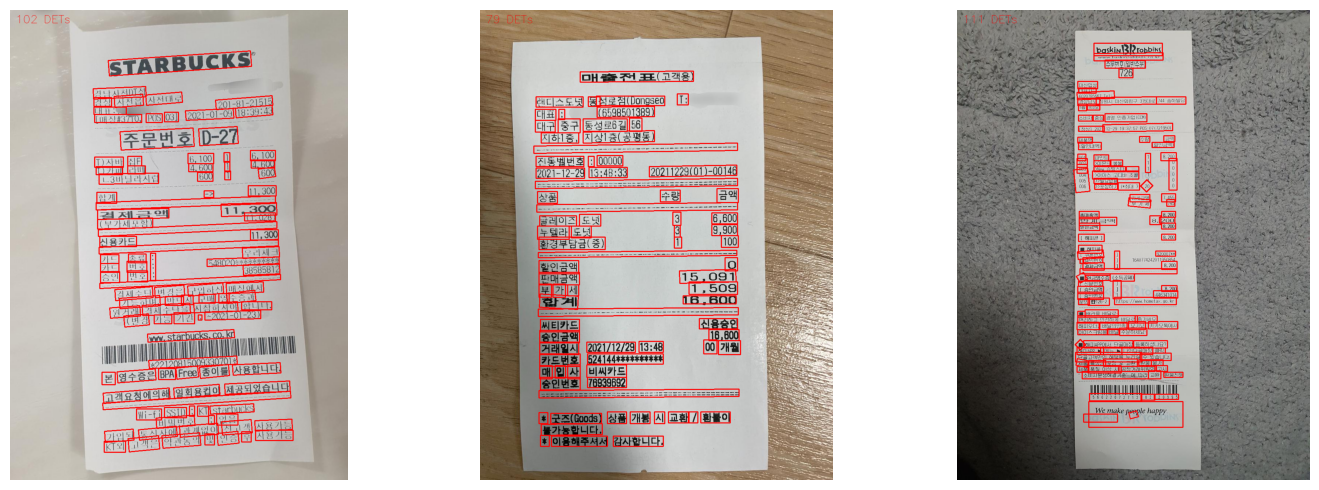

In [ ]:
#@title Ï∂îÎ°† Í≤∞Í≥º ÌõÑÏ≤òÎ¶¨ Î∞è ÏãúÍ∞ÅÌôî

# ÏãúÍ∞ÅÌôîÎ•º ÏúÑÌïú Î©îÏÜåÎìú
def draw_boxes(image, det_polys, det_color=(0, 0, 255), thickness=2):
    # Draw Detected Polygons
    cv2.putText(image, f"{len(det_polys)} DETs",
                (15, 35), cv2.FONT_HERSHEY_SIMPLEX, 1, det_color)
    for box in det_polys:
        box = np.array(box).reshape(-1, 2).astype(np.int32)
        cv2.polylines(image, [box], True, det_color, thickness=thickness)

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image


# ÌõÑÏ≤òÎ¶¨ Ïã§Ìñâ
post_processor = DBPostProcessor()
result_images = []
for idx, data in enumerate(batch):
    boxes_batch, scores_batch = post_processor.represent(data, preds[idx])
    result_images.append(draw_boxes(data['origin_images'][0], boxes_batch[0]))


# Í≤∞Í≥º ÏãúÍ∞ÅÌôî
# Ïù¥ÎØ∏ÏßÄ ÏàòÏóê Îî∞Îùº ÌñâÏùò Ïàò Í≥ÑÏÇ∞
n_rows = len(result_images) // 3 + int(len(result_images) % 3 > 0)

# Ïù¥ÎØ∏ÏßÄ ÌëúÏãú
plt.figure(figsize=(15, 5 * n_rows))
for i, image in enumerate(result_images):
    plt.subplot(n_rows, 3, i + 1)
    plt.imshow(image)
    plt.axis('off')

plt.tight_layout()
plt.show()